# Requirement 1: Single product and stochastic environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from math import isinf
from scipy.optimize import linprog

### Definition of the Pricing Environment 

We define a simple pricing environment where the win probability is computed for each price given a specific valuation. Then, at each round, the environment returns the units of products sold, which is 0 or 1 (the seller can sell only one unit of product per round) and the reward, which is current_price - cost. Moreover, the valuation is between 0 and 1.

In [ ]:
"""Definition of a pricing environment that simulates customer responses."""
class PricingEnvironment:

    def __init__(self, cost, prices, win_prob):
        """
        Pricing environment that simulates customer purchase behavior under different price levels
        Args:
            cost (float): the cost per unit of the product
            prices (array): discretized set of possible prices to offer
            win_prob (array): probability of selling the product at each price given a specific valuation
        """
        self.cost = cost
        self.prices = prices
        self.win_probabilities = win_prob

    def round(self, p_t, n_t, price):
        """Simulate a single round given price p_t and number of customers n_t
        Args:
            p_t: index of price chosen at time t
            n_t: number of potential customers
            price: price chosen at time t
        Returns:
            d_t: number of units sold
            r_t: revenue generated """
        d_t = np.random.binomial(n_t, self.win_probabilities[p_t])
        r_t = (price - self.cost)*d_t
        return d_t, r_t

### Definition of a UCB-Like agent

This agent is based on a UCB1 agent extended to deal with also a budget constraint. So, we have taken the UCB-like agent for general auctions and we extended it to the dynamic pricing with budget constraint. In particular, we have that:

1. The bids are now the prices, where $p_{t}$ is the price chosen at round t, and $ p_{t} \in [0,1] $.
2. Seller's utility is $ f_{t}(p_{t}) = p_{t} \mathbf{1}[v_{t} \geq p_{t}] $.
3. Seller's cost is $ c_{t}(p_{t}) = \mathbf{1}[v_{t} \geq p_{t}] $.
4. The budget is decreased by $ c_{t}(p_{t}) $ at each round if the customer buys, until is less than 1.

The algorithm computes at each round, the upper confidence bound (UCB) for the utility, and the lower confidence bound (LCB) for the cost as follows:
$$
f_{\text{ucbs}} = \text{avg\_f} + \text{range} \cdot \sqrt{\frac{2 \ln(T)}{N_{\text{pulls}}}}
$$

$$
c_{\text{lcbs}} = \text{avg\_c} - \text{range} \cdot \sqrt{\frac{2 \ln(T)}{N_{\text{pulls}}}}
$$
Then the optimal probability distribution over the prices is computed by solving the following LP:
$$
\begin{aligned}
\text{maximize } & f_{\text{ucbs}}^\top \gamma \\
\text{subject to } & c_{\text{lcbs}}^\top \gamma \leq \rho, \\
& \sum_{i=1}^{K} \gamma_i = 1, \\
& 0 \leq \gamma_i \leq 1, \quad i = 1, \dots, K
\end{aligned}
$$


In [ ]:
""" Definition of a UCB-like agent that optimizes pricing decisions while respecting a budget constraint."""
class UCBLikeAgent():
    def __init__(self, K, B, T, range=1):
        """
    UCB1-Like agent for pricing optimization.
    Args:
        K: number of discrete pricing options (arms).
        B: budget (number of products that can be sold overall)
        T: time horizon of the experiment.
        range: reward normalization factor (typically set to 1).
        """
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None # it's an index, not the actual bid
        self.avg_f = np.zeros(K)
        self.avg_c = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self):
        """
        Chooses which arm to pull. If the budget is exhausted, return -1. If still in initial exploration (t < K), pull each arm once.
        Otherwise, compute UCB estimates for rewards and LCB estimates for costs and balances exploration with budget constraints.
        Return:
            index of optimal price
        """
        if self.budget < 1:
            return -1
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma_t)
        return self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        """
        Compute the optimal gamma (probability distribution over the prices)
        Args:
            f_ucbs: UCB over utility
            c_lcbs: LCB over cost
        Return:
            probability distribution over prices    
        """

        # If all arms appear to have zero (or negative) cost lower-bounds,
        # we fall-back to greedy on f_ucbs (but still respect budget by using LP normally).
        if np.all(c_lcbs <= 0):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma

        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1.0]

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                            bounds=[(0,1)]*self.K, method='highs')
        if not res.success:
            # fallback: uniform
            gamma = np.ones(self.K) / self.K
        else:
            gamma = np.maximum(0, res.x)
            s = gamma.sum()
            gamma = gamma / s if s > 0 else np.ones(self.K)/self.K
        return gamma

    
    def update(self, f_t, c_t):
        """
        Updates the agent’s statistics after observing reward and cost: updates incremental mean for rewards and costs, 
        decreases remaining budget by actual cost and increases the time step.
        Args:
            f_t: utility
            c_t: cost
        """
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t])/self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

### Baseline

We define the baseline as the optimal policy knowing the win probabilities. It is obtained by solving the following LP:
$$
\begin{aligned}
\text{maximize } & \sum_i \gamma_i (\text{price}_i - \text{cost}) \cdot \text{win\_probability}_i \\
\text{subject to } & \sum_i \gamma_i \cdot \text{win\_probability}_i \le \rho, \\
& \sum_i \gamma_i = 1, \\
& 0 \le \gamma_i \le 1 \quad \forall i
\end{aligned}
$$


In [ ]:
"""Definition of a clairvoyant baseline solution ."""
def compute_clairvoyant(prices, rho, win_probabilities, cost=0.0):
    # maximize expected reward per round: (price-cost)*win_prob
    """
    Computes the optimal policy that knows the true win probabilities. Maximizes expected reward per round: (price - cost) * win_prob
     under an average budget constraint defined by rho.
    Returns:
      gamma: optimal probability distribution over arms (prices),
      value: expected reward of clairvoyant solution
    """
    c = - (prices - cost) * win_probabilities
    A_ub = [win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1.0]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                           bounds=(0,1), method='highs')
    gamma = res.x
    return gamma, -res.fun


### Trial with normal distribution for the valuations

We try the UCB-Like algorithm with the normal distribution for the valuation.

Budget:6500 Valuation:<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FA757E17F0> n_users:12000 rho:0.5416666666666666
Available prices =[0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952
 0.57142857 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381
 0.85714286 0.9047619  0.95238095 1.        ]
gamma=[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.72140418 0.27859582
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Expected utility=0.26


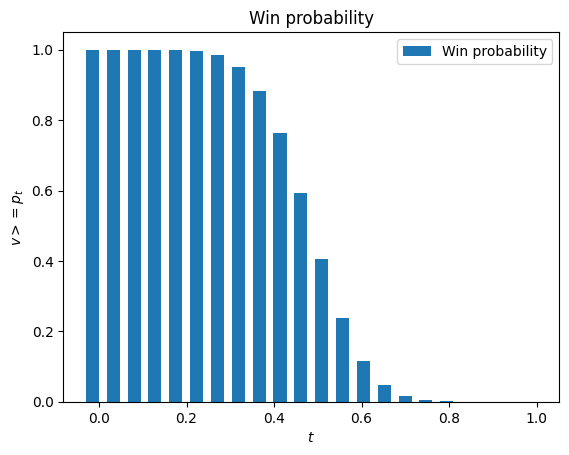

In [ ]:
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
valuation = stats.norm(loc=0.5, scale=0.1)
win_probabilities = 1 - valuation.cdf(prices)
gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, rho, win_probabilities)

print(f'Budget:{B} Valuation:{valuation} n_users:{T} rho:{rho}')
print(f'Available prices ={prices}')
print(f'gamma={gamma}')
print(f'Expected utility={expected_clairvoyant_utility:.2f}')
plt.title("Win probability")
width = 0.03
plt.bar(prices -width/2, win_probabilities, width=width, align='center', label='Win probability')
plt.xlabel('$t$')
plt.ylabel('$v >= p_t$')
plt.legend()
plt.show()
      

The win probability curve (bar plot) decreases with price, as expected from a Normal(0.5, 0.1) valuation. The demand drops beyond ~0.5.
The clairvoyant policy assigns positive probability only to two adjacent prices (~0.48 and ~0.52). 
This arises because of the budget constraint (rho ≈ 0.54) and the LP balances between neighboring price points to satisfy it.
The expected clairvoyant utility is ~0.26 per round, representing the maximum achievable reward under these constraints.

In [ ]:
# Here we define several hyperparameters, such as number of rounds T, the optimal number of arms K, and the discretized set of prices.
n_t = 1
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):
    # we compute the baseline assuming a normal distributed valuation
    valuation = stats.norm(loc=0.5, scale=0.1)
    win_probabilities = 1 - valuation.cdf(prices)
    gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, rho, win_probabilities)
    
    agent = UCBLikeAgent(K, B,T, range=1)
    env = PricingEnvironment(0, prices, win_probabilities)
    
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0

    np.random.seed(i)
    for u in range(T):
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(index, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        utilities.append(f_t)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)



Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500


"Total # of Wins" is equal to B=6500 across all 20 epochs. This confirms that the agent always spends exactly the available budget
(since each "win" corresponds to a unit of cost) satisfying the constraint.



<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_28936\3740400425.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_28936\3740400425.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


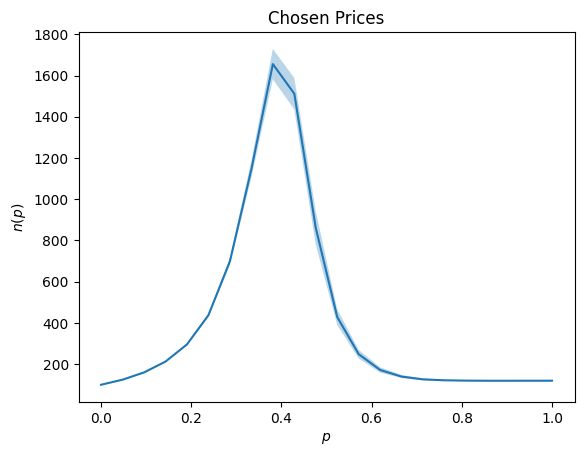

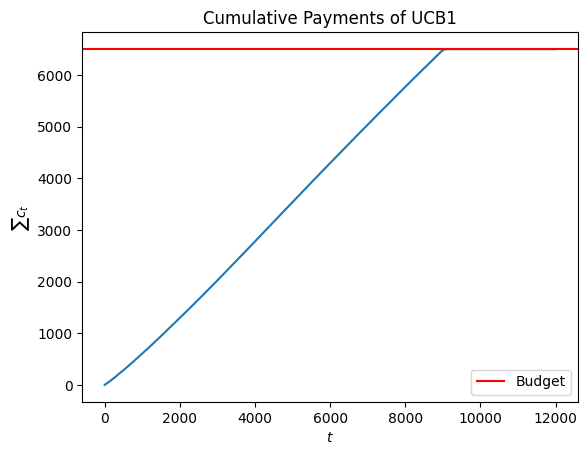

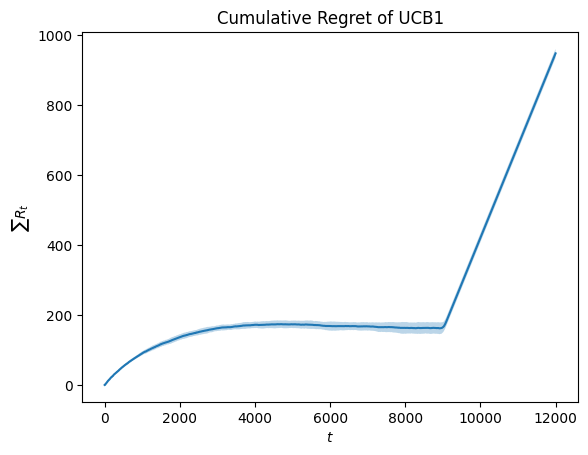

In [7]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$p$')
plt.ylabel('$n(p)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB1')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB1')
plt.show()

Chosen Prices (avg_pulls plot):
The agent pulls mostly two prices consistently with the optimal gamma mix and shows that the UCB-like agent learns to concentrate exploration there.

Cumulative Payments plot:  
Payments steadily grow and then plateau exactly at the budget limit .
This indicates the algorithm is respecting the budget while maximizing reward.

Cumulative Regret plot:
Initially the curve rises sublinearly while the UCB agent explores and learns which prices are profitable, respecting the budget. As learning progresses the agent makes increasingly better choices, so the increase in regret slows down.

Then the curve suddenly spikes. This corresponds to the point where the agent’s budget is exhausted since where the agent cannot pull any profitable arms, earning zero reward. 


### Trial with uniform distribution for the valuations

We try the UCB-Like algorithm with the uniform distribution for the valuation.

In [ ]:
# Here we define several hyperparameters, such as number of rounds T, the optimal number of arms K, and the discretized set of prices.
n_t = 1
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):
    # we compute the baseline assuming a uniform distributed valuation
    valuation = stats.uniform(loc=0, scale=1)
    win_probabilities = 1 - valuation.cdf(prices)
    gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, rho, win_probabilities)
    
    #agent and environment initialization
    agent = UCBLikeAgent(K, B,T, range=1)
    env = PricingEnvironment(0, prices, win_probabilities)
    
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0

    np.random.seed(i)
    for u in range(T):
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(index, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            # budget exhausted, so no sales possible
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

#averages and standard deviations across epochs
avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)



Total # of Wins: 6015
Total # of Wins: 5958
Total # of Wins: 5972
Total # of Wins: 6003
Total # of Wins: 6017
Total # of Wins: 6025
Total # of Wins: 5976
Total # of Wins: 6054
Total # of Wins: 6048
Total # of Wins: 6019
Total # of Wins: 5922
Total # of Wins: 6101
Total # of Wins: 5898
Total # of Wins: 6068
Total # of Wins: 5966
Total # of Wins: 5939
Total # of Wins: 6032
Total # of Wins: 6010
Total # of Wins: 6072
Total # of Wins: 6027


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_28936\3740400425.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_28936\3740400425.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


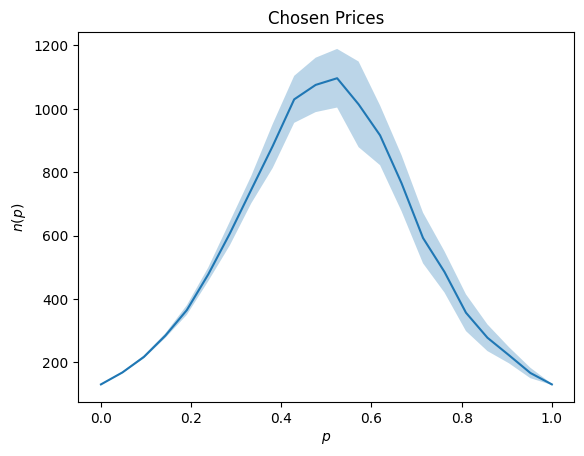

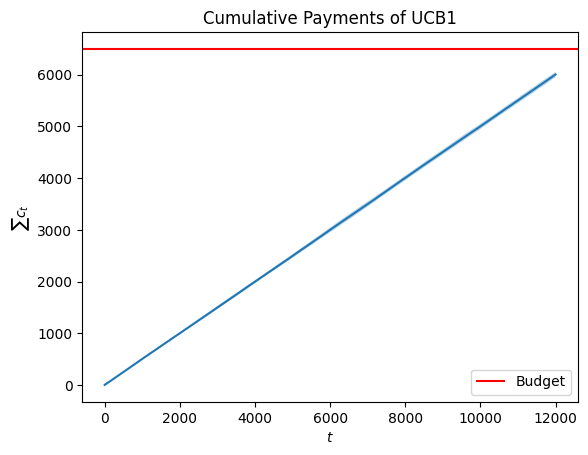

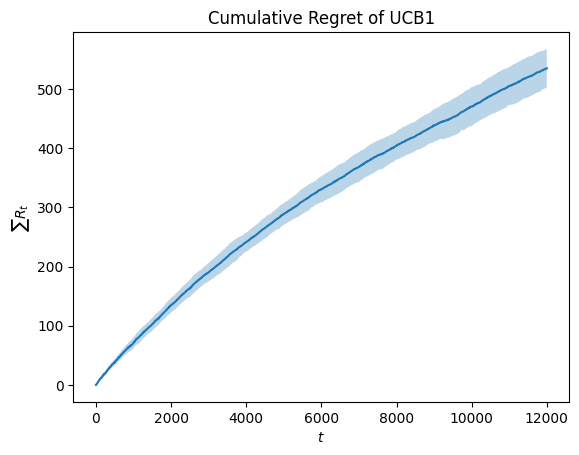

In [10]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$p$')
plt.ylabel('$n(p)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB1')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB1')
plt.show()


Chosen Prices (avg_pulls): 
The agent selects prices mostly around three consecutive prices.
This corresponds roughly to prices near the center of the uniform distribution, where the probability of winning  is neither too low nor too high.
The shaded area is wider than in the normal distribution, indicating higher variability in which prices are pulled across different simulation runs.

Cumulative Payments (avg_payments)
The cumulative payments increase over time but, unlike the normal distribution case, the cumulative payments never reach the total budget by the end of 12000 rounds. 

Cumulative Regret (avg_regret)
The cumulative regret curve increases over time, reflecting the gap between the UCB-like agent’s utility and the clairvoyant optimal utility.
The shaded area around the curve grows as t increases showing increasing variability in regret across epochs.
The regret is lower in the beginning (as the agent explores) and gradually accumulates as the horizon progresses.
Since the agent never fully exploits the highest-utility prices due to uniform valuations, the regret remains non-zero and the shaded region becomes wider over time.


### Trial with beta distribution for the valuations

We try the UCB-Like algorithm with the beta distribution for the valuation.

In [ ]:
# Here we define several hyperparameters, such as number of rounds T, the optimal number of arms K, and the discretized set of prices.
n_t = 1
T = 12000
B = 6500
rho = B/T
epsilon = T**(-0.33)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):
    # we compute the baseline assuming a beta distributed valuation
    valuation = stats.beta(a=3, b=2)
    win_probabilities = 1 - valuation.cdf(prices)
    gamma, expected_clairvoyant_utility = compute_clairvoyant(prices, rho, win_probabilities)
    
    agent = UCBLikeAgent(K, B,T, range=1)
    env = PricingEnvironment(0, prices, win_probabilities)
    
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0

    np.random.seed(i)
    for u in range(T):
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(index, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)



Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500
Total # of Wins: 6500


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_28936\3740400425.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_28936\3740400425.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


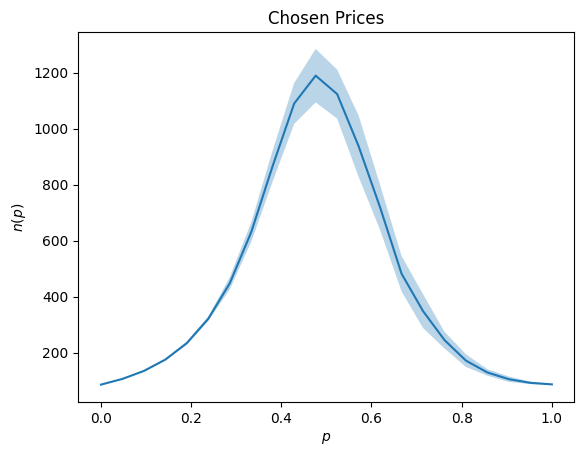

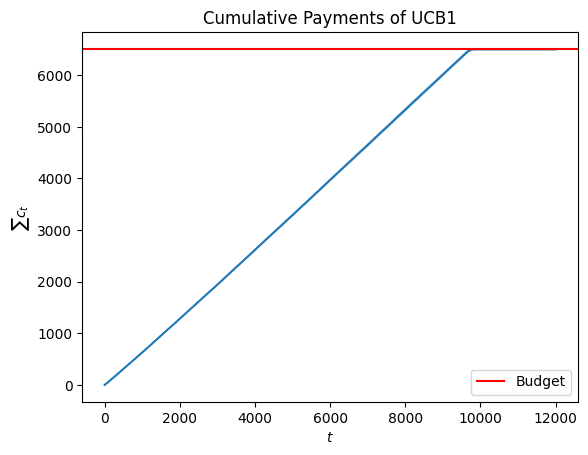

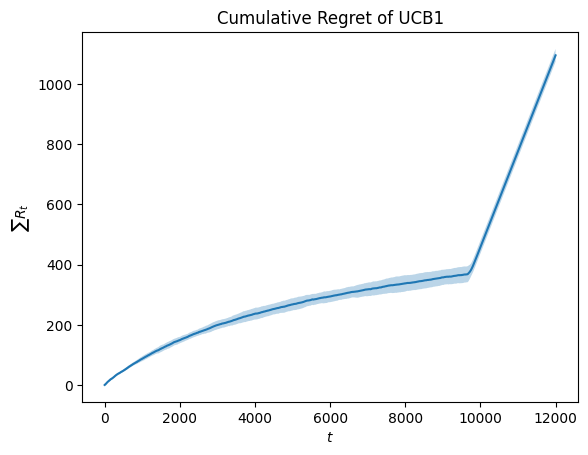

In [12]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$p$')
plt.ylabel('$n(p)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB1')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB1')
plt.show()

Chosen Prices (avg_pulls)
The agent tends to select prices concentrated at three adjacent values in the middle of the price grid.
The shaded area is wider than in the normal case, indicating more variability in which prices are pulled across different simulation runs.

Cumulative Payments (avg_payments)
The cumulative payments  increase and reach the budget slightly before round t = 10000. 

Cumulative Regret (avg_regret)
The cumulative regret curve rises sublinearly as the agent explores and suddenly spikes when the budget is exhausted.